---

title: 图像基础用法
keywords: jupyter， MaixPy3 IDE， 图像获取，图像显示，图像处理
desc: maixpy doc: 如何显示一张图，如何获取一张图，如何修改一张图

---

> 2022年01月11日 在 V83X 与 R329 硬件上使用 maixpy3 0.3.6 版本以上通过测试


## 创建并显示一张图片

这需要 display 和 image 的接口功能。

- img = image.Image() 支持创建一张空白的 RGB 图像，内置 RGB 的排列方式是 NHWC 例如下图。

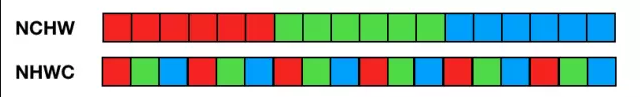

- img.new(size=(240, 240), mode="RGB") ，意味着生成一张大小为 240x240 的 RGB 图像。
- display.show(img) 支持 show PIL 或 image 生成的图像显示出来，但物理屏幕会进行自适应的拉伸。
- str(img) 序列化图像的类型，方便查看内部参数

如果不做特殊说明，以下所有图像操作均以 NHWC RGB24（RGB888） 为标准，下图为 BGR24 示意图。

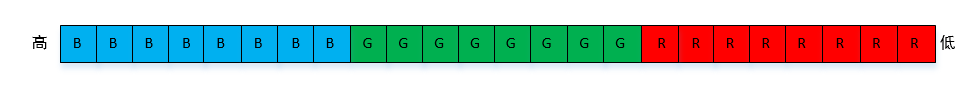

所谓 RGB 和 BGR 只是交换了以下 R 和 B 数据位置，除此之外还有 RGB565 \ RGB666 \ RGBA 等常见格式，细节此处不做展开说明，文末附录会说明一下 YUV 和 RGB 常见图像类型说明。


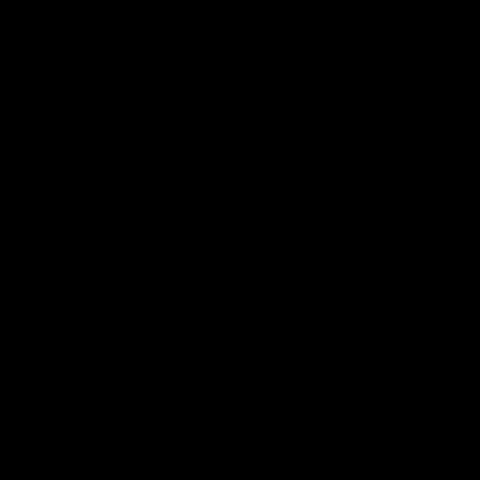

[ rpyc-kernel ]( running at Tue Jan 11 12:00:25 2022 )
<_maix_image.Image 0x973d90 " width":240, "height":240, "type"=RGB, "size":172800>


In [1]:
from maix import image, display

img = image.Image()

img.new(size=(240, 240), mode="RGB")

print(str(img))

display.show(img)


## 图像的基础绘图操作

有了图片就可以做一些基础的绘图操作，比如说：

- draw_line 画线
- draw_rectangle 画框
- draw_circle 画圆
- draw_string 写字
- draw_image 贴图
- draw_ellipse 椭圆

基础用法如下：


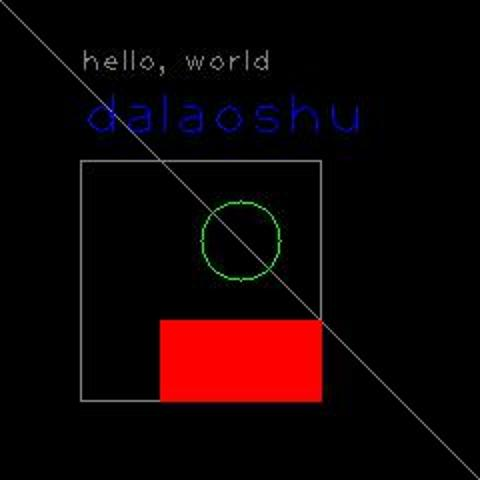

[ rpyc-kernel ]( running at Tue Jan 11 13:09:25 2022 )


In [1]:
from maix import image, display

img = image.Image()

img.new(size=(240, 240), mode="RGB")

img.draw_line(0, 0, 240, 240)

img.draw_rectangle(40, 80, 160, 200)
img.draw_rectangle(80, 160, 160, 200, color=(255, 0, 0), thickness=-1)

img.draw_circle(120, 120, 20, color=(0, 255, ))

img.draw_string(40, 20, "hello, world")

img.draw_string(40, 40, "dalaoshu", 2, color=(0, 0, 255))

# 椭圆用法解释过于复杂，只介绍常用的基本功能。
# img.draw_ellipse(120, 40, 20, 50, 90, 0, 360, color=(0,255,0), thickness = 1)

# img.draw_image(img) # 贴图操作

display.show(img)


## 保存并打开一张图片

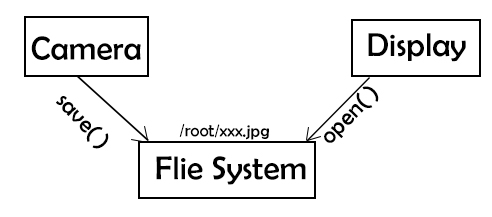

承接上文得到了一张自己绘制的图片，那么不妨来保存它，并且打开它或从内存中恢复出来。

- img.save("/root/test.png") 保存到 root 根目录下，后缀可以是 jpg bmp png 等等编码格式。

- img.open("/root/test.png") 打开一张目录下的图片，与 save 对称。


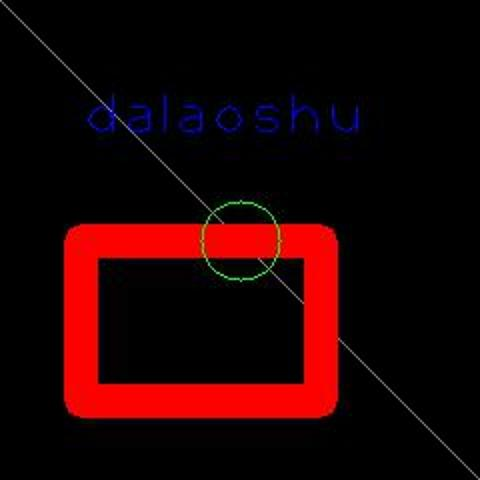

[ rpyc-kernel ]( running at Tue Jan 11 13:16:46 2022 )


In [1]:
from maix import image, display

img = image.Image()

img.new(size=(240, 240), mode="RGB")
img.draw_line(0, 0, 240, 240)
img.draw_rectangle(40, 120, 160, 200, color=(255, 0, 0), thickness=16)
img.draw_circle(120, 120, 20, color=(0, 255, 0))
img.draw_string(40, 40, "dalaoshu", 2, color=(0, 0, 255))

img.save("/root/test.png")

tmp = image.Image()
tmp.open("/root/test.png")

display.show(tmp)

## 从内存中恢复一张图片

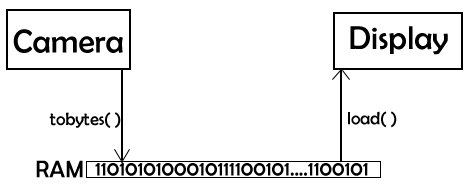

除了上述的方法，我们还可以借助 img.tobytes() 可以将 img 图像导出一个 bytes 字符串，再通过 img.load 恢复原图，这通常发生在图传数据的场合。

- img.tobytes() 转换图像数据为数组字符串。

- img.load() 加载数组字符串作为图像数据使用，这需要已知图像的排列方式和数据大小进行数据的还原。

需要注意的就是数据的长度和排列的方式要已知，尤其是 RGB 和 BGR 会不小心弄混。


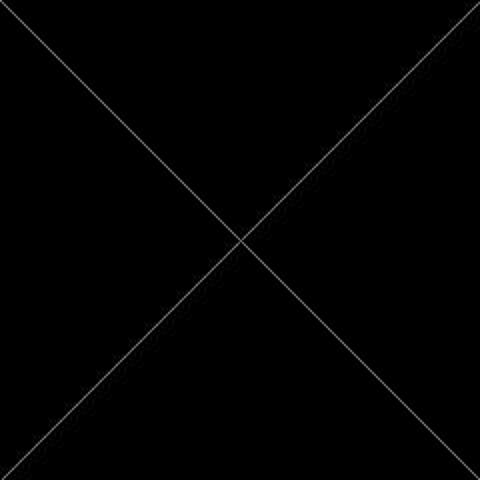

[ rpyc-kernel ]( running at Tue Jan 11 13:31:34 2022 )


In [1]:
from maix import image, display

img = image.Image()

img.new(size=(240, 240), mode="RGB")
img.draw_line(0, 0, 240, 240)
img.draw_line(0, 240, 240, 0)
data = img.tobytes()

tmp = image.Image()
tmp.load(data, size=(240, 240), mode="RGB")
display.show(tmp)

## 从摄像头获取一张图像

> 小提示：在循环代码中使用 print 会导致系统明显卡顿和延迟。

上述的图像都是来自于自己创建，如果想要外部输入一张图像，就可以使用。

- camera.capture() 获取一张 image 图像，与上述用法一致。

![](./../asserts/camera_1.gif)

一般情况下 camera 生成的图像大小与 display 的大小一致。

如果想要改变可以使用 camera.config(size=(224, 224)) 但要慎重使用这个接口，下文会做出解释。


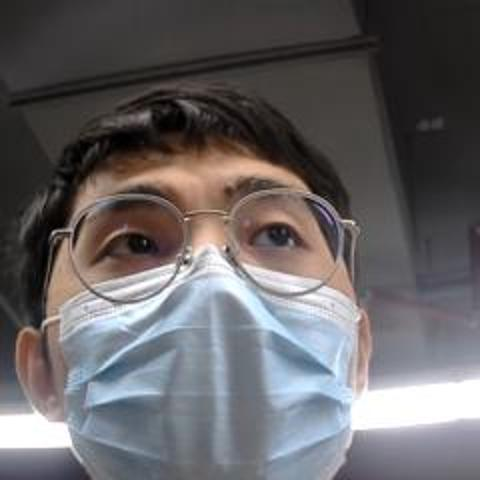

[ rpyc-kernel ]( running at Tue Jan 11 14:16:01 2022 )
<_maix_image.Image 0x19fce40 " width":240, "height":240, "type"=RGB, "size":172800>


In [1]:

from maix import image, display, camera

img = camera.capture()

display.show(img)

print(str(img))


## 典型的图像缩放场景

> 这是我们在开发视觉 AI 应用开发时总结下来的场景经验。

推荐使用 resize 而不是改变摄像头输入，摄像头的输入大小应当与屏幕一致，这是因为落地场景下整体的应用框架决定的。

```
┌───────────────────────────────────────┐
│    320x240                            │
│  ┌─────────┐                          │
│  │         │         224x224          │
│  │ camera  ├────────────────────┐     │
│  │         │                    ▼     │
│  └────┬────┘               ┌────────┐ │
│       │                    │        │ │
│       │ draw ┌───────┐     │        │ │
│       │◄─────┤ text  ├─────┤   nn   │ │
│       │      └───────┘     │        │ │
│  ┌────▼────┐               │        │ │
│  │         │               └────────┘ │
│  │ display │                          │
│  │         │                          │
│  └─────────┘                          │
│    320x240                            │
└───────────────────────────────────────┘
```

看上图示意，在落地的使用场景里 camera 通常要直出到 display 画面，而 nn 由于模型的输入尺寸导致需要从 320x240 缩放到 224x224 大小。

如果我们将 camera 的输入图像设置成 224x224 会发生什么？

它会在原图的基础上进行最大比例矩形裁剪与缩放（ 320x240 > 240x240 > 224x224 ），那就会导致 camera 对原图进行裁剪后送入 nn 会导致丢失图像的边缘，如果是主流的摄像头输入大小，则呈现（ 1920x1080 > 1080x1080 > 224x224 ）的效果，此时丢失的数据会更多，还会发现摄像头的视角变小了。

**所以为了尽量保留有效数据，会使用 copy 和 resize 进行图像的缩放（而非裁剪），这会导致一定的变形，但边缘数据的信息量会被保留，同时不会改变原图。**

而改变摄像头输入的大小丢失了数据后，同时在 display 图像的时候又需要从 224x224 恢复成 320x240 ，显然 resize 回去会导致模糊和变形，这样效果会更加糟糕，因此综上所述，此时的代码结构应该如下：


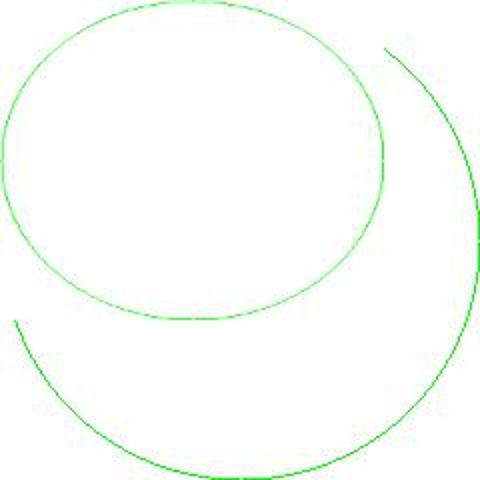

[ rpyc-kernel ]( running at Tue Jan 11 15:30:22 2022 )
<_maix_image.Image "width":192, "height":160, "type"=RGB, "size":92160>


In [1]:

from maix import image, display

img = image.Image()
# 准备一张原图
img.new(size=(240, 240), color=(255, 255, 255), mode="RGB")
img.draw_circle(120, 120, 120, color=(0, 255, 0))

# 拷贝一张新图出来并 resize 后送入 nn 模块
tmp = img.copy().resize(192, 160)
img.draw_image(tmp) # 贴张图示意
print(tmp)

# 原图依旧显示出来
display.show(img)

# # 这表示在对当前图像 resize 尺寸，会导致 display 显示的时候重新 resize 回 240x240。
# img.resize(224, 224)
# print(img)


## 附录：关于图像格式的补充说明

最后说点什么吧？

我们在上面所操作的对象的都是 rgb 图像，但实际上图像背后是存在了很多变换操作的。

这一条路径可以描述成：

- 从摄像头 sensor 获取到 RAW12 / YUV422 / JPG 这类原始数据，想要得到 RGB 图像则需要对其各种转换。
- 如 RAW 经过 ISP 转 YUV 、 USB 摄像头直出 YUV 转 RGB 图像，又或是解码 JPG 变回 RGB 等图像转换操作。

而在 maixpy3 中，图像的获取和显示已经被内置的方法自动转换成了 RGB888 ，但背后可能会存在类似 YUV 图像格式，下图为 YUV 示意。

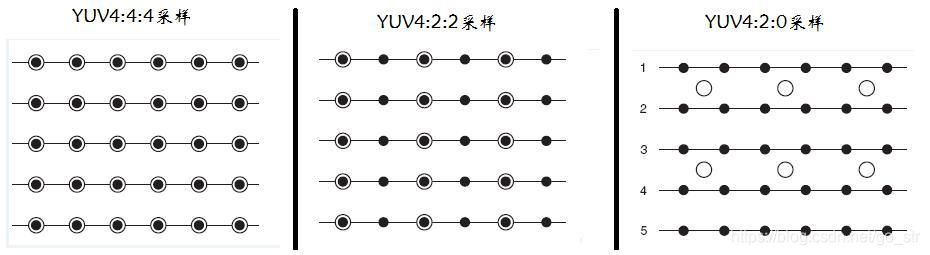

为了能满足落地所需要的性能，maixpy3 图像操作是基于 opencv C/C++ 写的，不同于 CV2 或者 PIL 这类桌面常见图像处理库，所以在低端硬件上也能有不错的效果表现，如果想深入可以自己琢磨琢磨 maixpy3 / libmaix 的开源仓库，此处所有操作都与 libmaix sdk 保持一致。